In [157]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns

In [158]:
class Layer(object):

    def __init__(self):
        pass

    def forward(self, input_):
        return self._output(input_)

    def backprop(self, backprop_grad):
        return self._backprop(backprop_grad)

    def _output(self, input_):
        raise NotImplementedError()

    def _backprop(self, backprop_grad):
        raise NotImplementedError()

In [159]:
class ParamLayer(Layer):

    def __init__(self, input_size, neurons):
        super().__init__()
        self.neurons = neurons
        self.input_size = input_size

        self._init_params()

    def forward(self, input_):
        self.input_ = input_
        return self._output()

    def _backprop(self, backprop_grad):
        self._param_grads(backprop_grad)

        return self._input_grad(backprop_grad)

    def _param_grads(self, backprop_grad):
        raise NotImplementedError()

    def _input_grad(self, backprop_grad):
        raise NotImplementedError()

    def _init_params(self):
        raise NotImplementedError()

In [160]:
class Linear(ParamLayer):

    def __init__(self, input_size, neurons):
        super().__init__(input_size, neurons)

    def _init_params(self):
        self.params = []
        self.params.append(np.random.normal(size=(self.input_size, self.neurons)))
        self.params.append(np.random.normal(size=(1, self.neurons)))

    def _output(self):
        return np.dot(self.input_, self.params[0]) + self.params[1]

    def _param_grads(self, backprop_grad):
        self.param_grads = []
        self.param_grads.append(np.dot(self.input_.T, backprop_grad))
        self.param_grads.append(np.sum(backprop_grad, axis=0).reshape(1, self.neurons))

    def _input_grad(self, backprop_grad):
        return np.dot(backprop_grad, self.params[0].T)

In [161]:
class Sigmoid(Layer):

    def __init__(self):
        super().__init__()

    def _output(self, input_):
        self.output = 1.0/(1.0+np.exp(-1.0*input_))
        return self.output

    def _backprop(self, backprop_grad):
        return (self.output * (1.0 - self.output)) * backprop_grad

In [162]:
class Tanh(Layer):

    def __init__(self):
        super().__init__()

    def _output(self, input_):
        self.output = np.tanh(input_)
        return self.output

    def _backprop(self, backprop_grad):
        return (1.0 - self.output**2) * backprop_grad

In [163]:
class Model(object):

    def __init__(self, layers=[]):
        self.layers = layers

    def forward(self, input_):
        output = input_
        for layer in self.layers:
            output = layer.forward(output)

        return output

    def backprop(self, backprop_grad):
        back_grad = backprop_grad
        for layer in reversed(self.layers):
            back_grad = layer.backprop(back_grad)

        self._param_grads()

    def parameters(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param in layer.params:
                    params.append(param)
        return params

    def _param_grads(self):
        self.param_grads = []
        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_grad in layer.param_grads:
                    self.param_grads.append(param_grad)

In [164]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self, y_pred, y_target):
        
        return self._output(y_pred, y_target)

    def backprop(self, y_pred, y_target):
        
        return self._backprop(y_pred, y_target)

In [165]:
class MeanSquaredError(Loss):

    def __init__(self):
        super().__init__()

    def _output(self, y_pred, y_target):
        return np.mean(np.sum((y_pred - y_target)**2, axis=1))

    def _backprop(self, y_pred, y_target):
        return 2.0 * (y_pred - y_target)/y_target.shape[0]

In [166]:
class Optimiser(object):

    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr
        self.params = self.model.parameters()

    def step(self):
        self._train()

    def _train(self):
        raise NotImplementedError()

In [167]:
class SGDOptimiser(Optimiser):

    def __init__(self, model, lr=0.01):
        super().__init__(model, lr)

    def _train(self):

        for param, param_grad in zip(self.params, self.model.param_grads):

            param -= param_grad * self.lr

In [168]:
class DataLoader(object):

    def __init__(self,
                x_train,
                y_train,
                batch_size,
                shuffle=False):

        self.batch_size = batch_size
        self.x_train = x_train
        self.y_train = y_train
        self.data_len = self.x_train.shape[0]
        self.shuffled = shuffle

    def shuffle(self):
        indexing = np.random.permutation(self.data_len)
        self.x_train_sh, self.y_train_sh = self.x_train[indexing], self.y_train[indexing]

    def get_batch(self):
        for ii in range(0, self.data_len, self.batch_size):
            if self.shuffled:
                yield self.x_train_sh[ii:ii+self.batch_size], self.y_train_sh[ii:ii+self.batch_size]
            else:
                yield self.x_train[ii:ii+self.batch_size], self.y_train[ii:ii+self.batch_size]

In [169]:
class TrainNetwork(object):

    def __init__(self,
                model,
                loss_function,
                optimiser,
                data_loader,
                epochs=100,
                eval_every=10):
        self.model = model
        self.loss_function = loss_function
        self.optimiser = optimiser
        self.data_loader = data_loader
        self.epochs = epochs
        self.shuffle = self.data_loader.shuffled
        self.eval_every = eval_every

    def fit(self, x_test, y_test):

        for epoch in range(self.epochs):
            if self.shuffle:
                self.data_loader.shuffle()

            for x_train, y_train in self.data_loader.get_batch():

                y_pred = self.model.forward(x_train)
                loss_grad = self.loss_function.backprop(y_pred, y_train)
                self.model.backprop(loss_grad)

                self.optimiser.step()

            if (epoch + 1) % self.eval_every == 0:
                y_pred = self.model.forward(x_test)
                loss = self.loss_function.forward(y_pred, y_test)
                print("Loss:", loss)

In [170]:
x = np.linspace(0, 1.0, 200)
y = 1.0*x + np.sin(x * 10.0) * 0.15 + np.random.normal(size=(x.shape[0],)) * 0.04

x_train, y_train = x.reshape(-1, 1), y.reshape(-1, 1)

In [171]:
model = Model([
    Linear(1, 10),
    Tanh(),
    Linear(10, 10),
    Tanh(),
    Linear(10, 1)
])

In [172]:
data_loader = DataLoader(x_train, y_train, 40, True)
loss_function = MeanSquaredError()
optimiser = SGDOptimiser(model=model, lr=0.05)

In [173]:
trainer = TrainNetwork(model, loss_function, optimiser, data_loader, 1000, 100)

In [174]:
trainer.fit(x_train, y_train)

Loss: 0.011170831600287656
Loss: 0.009635685172329635
Loss: 0.009109993182243818
Loss: 0.007560961107533221
Loss: 0.007092902008346018
Loss: 0.004860279308063545
Loss: 0.0035985889375453797
Loss: 0.002601211386993396
Loss: 0.0022587436257141737
Loss: 0.0018884293068799146


In [175]:
y_pred = model.forward(x_train)

/home/ivan/miniconda3/envs/env1/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ivan/miniconda3/envs/env1/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

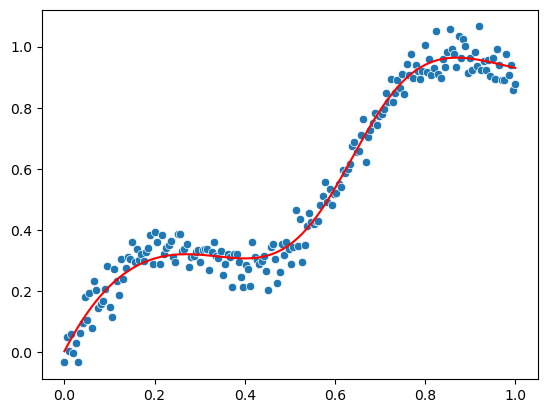

In [176]:
sns.scatterplot(x=x, y=y)
sns.lineplot(x=x, y=y_pred.reshape(200), color='red')